Iteration 1/20
Training on client 1/10
Training on client 2/10
Training on client 3/10
Training on client 4/10
Training on client 5/10
Training on client 6/10
Training on client 7/10
Training on client 8/10
Training on client 9/10
Training on client 10/10
Iteration 2/20
Training on client 1/10
Training on client 2/10
Training on client 3/10
Training on client 4/10
Training on client 5/10
Training on client 6/10
Training on client 7/10
Training on client 8/10
Training on client 9/10
Training on client 10/10
Iteration 3/20
Training on client 1/10
Training on client 2/10
Training on client 3/10
Training on client 4/10
Training on client 5/10
Training on client 6/10
Training on client 7/10
Training on client 8/10
Training on client 9/10
Training on client 10/10
Iteration 4/20
Training on client 1/10
Training on client 2/10
Training on client 3/10
Training on client 4/10
Training on client 5/10
Training on client 6/10
Training on client 7/10
Training on client 8/10
Training on client 9/10
T

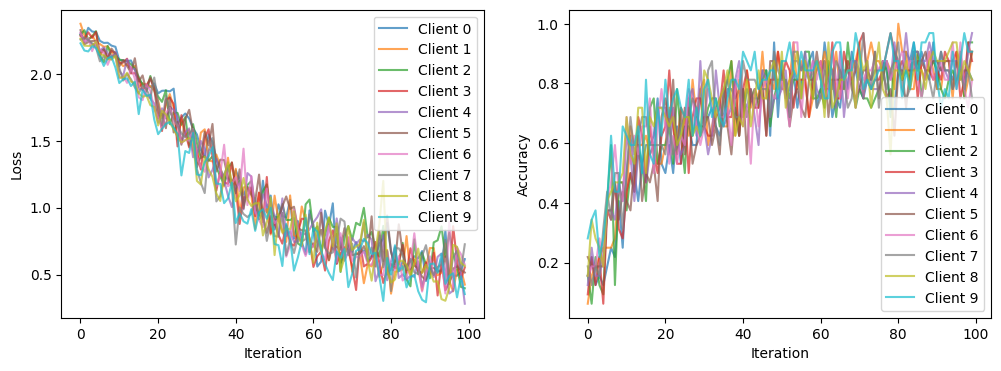

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib for visualization

# Load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define a deeper model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Define loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Define the number of clients
num_clients = 10

# Split the training data into clients
x_train_split = np.array_split(x_train, num_clients)
y_train_split = np.array_split(y_train, num_clients)

# Federated learning iterations
num_iterations = 20  # Increase the number of iterations

# Create empty lists to store training loss and accuracy for each client during federated learning iterations
loss_history = [[] for _ in range(num_clients)]
accuracy_history = [[] for _ in range(num_clients)]

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Iterate through each client
    for client_id in range(num_clients):
        print(f"Training on client {client_id + 1}/{num_clients}")

        # Clone the model for the client
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Define the optimizer for the client
        client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

        # Train the client's local model
        for _ in range(5):  # Local client training iterations
            idx = np.random.randint(0, len(x_train_split[client_id]), size=32)
            x_batch = x_train_split[client_id][idx]
            y_batch = y_train_split[client_id][idx]

            with tf.GradientTape() as tape:
                predictions = client_model(x_batch)
                loss = loss_fn(y_batch, predictions)
            grads = tape.gradient(loss, client_model.trainable_variables)

            # Apply gradients using the client optimizer
            client_optimizer.apply_gradients(zip(grads, client_model.trainable_variables))

            # Record training loss and accuracy for the client
            loss_history[client_id].append(loss)
            accuracy = np.mean(np.argmax(predictions, axis=1) == y_batch)
            accuracy_history[client_id].append(accuracy)

        # Update the central server model
        global_weights = model.get_weights()
        client_weights = client_model.get_weights()
        averaged_weights = [
            (global_weight + client_weight) / 2
            for global_weight, client_weight in zip(global_weights, client_weights)
        ]
        model.set_weights(averaged_weights)

# Evaluation on a test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot loss and accuracy for each client on a single graph with different colors
plt.figure(figsize=(12, 4))
for client_id in range(num_clients):
    plt.subplot(1, 2, 1)
    plt.plot(loss_history[client_id], label=f'Client {client_id}', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history[client_id], label=f'Client {client_id}', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()
